# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup, train and deploy your model. This notebook will show how to run the Argo jobs and example prediction calls to the deployed models.

**To run this notebook you will need to install Tensorflow**
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

In [1]:
import sys
sys.path.append('proto')

# Submit tensorflow training job


In [2]:
!argo submit ../workflows/training-tf-mnist-workflow.yaml -p tfjob-version-hack=$RANDOM

Name:             kubeflow-tf-train-xrmqb
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Apr 10 15:55:42 -0300 (27 seconds ago)
Parameters:       
  tfjob-version-hack: 31071
  version:        0.1
  github-user:    kubeflow
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


In [46]:
!argo list

NAME                      STATUS      AGE    DURATION
kubeflow-sk-train-2z5mt   Running     5s     5s 
kubeflow-sk-train-zsmsm   Succeeded   22h    1h 
seldon-sk-deploy-6k2kv    Succeeded   1d     3s 
seldon-sk-deploy-s66jf    Succeeded   1d     20s 
seldon-sk-deploy-95b8x    Succeeded   1d     3s 
kubeflow-sk-train-gq8m9   Succeeded   1d     6m 
kubeflow-tf-train-xrmqb   Succeeded   1d     2m 


# Serve tensorflow model


In [35]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" configured


# Submit scikit-learn training job


In [4]:
!argo submit ../workflows/training-sk-mnist-workflow.yaml

Name:             kubeflow-sk-train-8zjhl
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Mon Apr 16 09:35:18 -0300 (1 second ago)
Parameters:       
  version:        0.3
  github-user:    smolina74
  github-revision: master
  docker-user:    smolina74
  build-push-image: true


# Serve scikit-learn model


In [3]:
!argo submit ../workflows/serving-sk-mnist-workflow.yaml

Name:             seldon-sk-deploy-bsdzd
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Sun Apr 22 19:59:53 -0300 (now)
Parameters:       
  version:        0.3
  github-user:    smolina74
  github-revision: master
  docker-user:    smolina74
  build-push-image: true


# Mnist Setup
You will need Tensorflow installed to run this section.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


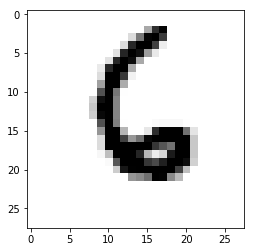

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

Create proto files for gRPC. You will need [python grpc tools](https://grpc.io/docs/quickstart/python.html) installed

In [5]:
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [4]:
import requests
from requests.auth import HTTPBasicAuth
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json
from visualizer import get_graph

AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    payload = {'json': json.dumps(request)}
    response = requests.post(
        "http://" + AMBASSADOR_API_IP + "/skmnist/prediction/predict",
                data=payload)
            
    print(response)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print(response.status_code)
    return response.json()   

def grpc_request(deploymentName,data):
    print('within grpc_request')
    print(type(data))
    print(data)
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    print(datadef)
    print('-------')
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print(response)


# Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pod -l service=ambassador -o jsonpath='{.items[0].metadata.name}')  8002:80
```

If the tensorflow model has not been deployed you can directly use the kubernetes manifest for it to deploy

#### REST Request

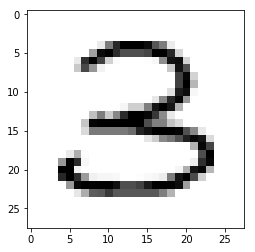

<Response [200]>
<type 'dict'>
{
  "meta": {
    "puid": "9m6lfcciho1pmhf8eig4bgh931", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    "ndarray": [
      [
        6.188569841469871e-06, 
        3.1495314942731056e-06, 
        0.02469996176660061, 
        0.9743489027023315, 
        5.91392999922391e-05, 
        0.0005414581974036992, 
        1.4482539256732707e-07, 
        3.262571723894325e-08, 
        0.00034073545248247683, 
        2.819593021285982e-07
      ]
    ]
  }
}


In [24]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()

data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}

predictions = rest_request("mnist-classifier", request)
print type(predictions)
print(json.dumps(predictions, indent=2))